In [1]:
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, GRU

In [2]:
label = np.load('./local_dir/concatnated_label.npy')
path = './local_dir/keypoints_data/'

In [3]:
arrays = []

for filename in tqdm(os.listdir(path)):
    file_path = os.path.join(path, filename)
    array = np.load(file_path)
    arrays.append(array)

combined_array = np.concatenate(arrays, axis=0)
combined_array.shape

  0%|          | 0/8380 [00:00<?, ?it/s]

100%|██████████| 8380/8380 [00:03<00:00, 2151.70it/s]


(902205, 33, 3)

In [4]:
le = LabelEncoder()

y_data = le.fit_transform(label)

print(combined_array.shape)
print(y_data.shape)

(902205, 33, 3)
(902205,)


In [6]:
np.unique(y_data)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [7]:
y_data = to_categorical(y_data, num_classes=420)

In [8]:
x_data = combined_array.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_test, y_train, y_test = train_test_split(combined_array, y_data, test_size=0.2)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)
print(x_train.shape[1], x_train.shape[2])

(721764, 33, 3) (180441, 33, 3)
(721764, 420) (180441, 420)
33 3


In [9]:
def create_GRU_model():
    inputs = tf.keras.Input(shape=(x_train.shape[1], x_train.shape[2]))
    
    x = tf.keras.layers.GRU(64, return_sequences=True)(inputs)
    x = tf.keras.layers.GRU(128, return_sequences=True)(x)
    x = tf.keras.layers.GRU(256, return_sequences=False)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = create_GRU_model()
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 33, 3)]           0         
_________________________________________________________________
gru (GRU)                    (None, 33, 64)            13248     
_________________________________________________________________
gru_1 (GRU)                  (None, 33, 128)           74496     
_________________________________________________________________
gru_2 (GRU)                  (None, 256)               296448    
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896 

In [10]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
hist = model.fit(x_train, y_train, epochs=70, validation_split=0.2)

Epoch 1/70
18045/18045 [==============================] - 247s 13ms/step - loss: 5.3479 - accuracy: 0.0282 - val_loss: 4.6796 - val_accuracy: 0.0728
Epoch 2/70
16289/18045 [==========================>...] - ETA: 21s - loss: 4.4497 - accuracy: 0.0913

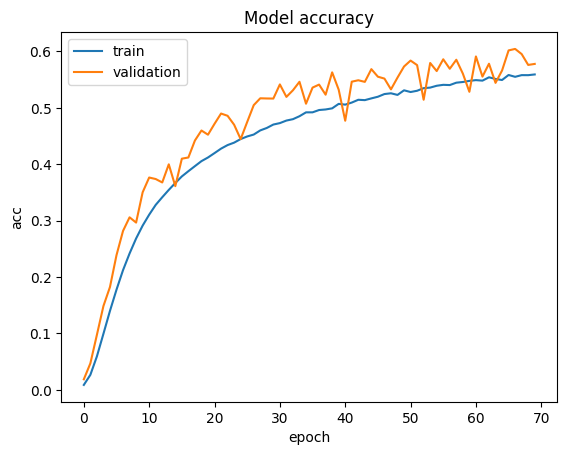

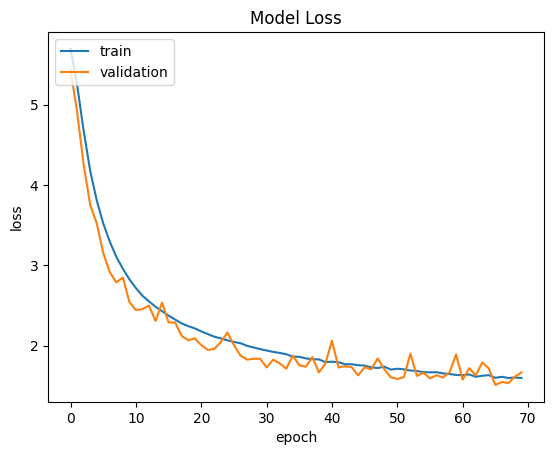

In [55]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()